In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Load the libraries

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import os
tf.random.set_seed(42)
from tensorflow.keras.applications.densenet import DenseNet201,DenseNet121,DenseNet169
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy.stats import entropy


# Data Loading and preprocessing

In [ ]:
### se usiamo il set train/val/test sono 7 labels. quello originale 12
label_length=7
def record_parser(example):
    example_fmt = {'img': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label': tf.io.FixedLenFeature([label_length], tf.int64), 
        'path': tf.io.FixedLenFeature([], tf.string),
        "report": tf.io.FixedLenFeature([], tf.string)
    }
    parsed = tf.io.parse_single_example(example, example_fmt)
    
    #image = tf.io.decode_image(parsed["img"],channels=3)
    image=tf.cast(tf.reshape(tf.io.decode_raw(parsed["img"], tf.float32), shape=(224,224,3)), dtype=tf.float32)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    return image, parsed["label"], parsed["path"], parsed["report"]

def record_parser_img_label(example):
    example_fmt = {'img': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label': tf.io.FixedLenFeature([label_length], tf.int64), 
        'path': tf.io.FixedLenFeature([], tf.string),
        "report": tf.io.FixedLenFeature([], tf.string)
    }
    parsed = tf.io.parse_single_example(example, example_fmt)
    
    #image = tf.io.decode_image(parsed["img"],channels=3)
    image=tf.cast(tf.reshape(tf.io.decode_raw(parsed["img"], tf.float32), shape=(224,224,3)), dtype=tf.float32)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    return image, parsed["label"]

def load_tfexamples(full_path, batch_size=8):
    dataset = tf.data.TFRecordDataset(full_path)
    parsed_dataset = dataset.map(record_parser_img_label,num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(batch_size, drop_remainder=False).prefetch(1)
    print(parsed_dataset)
    # for el in parsed_dataset:
    #     print(el[1])
    #     plt.figure()
    #     plt.imshow(el[0][0,:,:,0], cmap="gray")
    #     break
    return parsed_dataset
batch_size=1
base_path= '/content/drive/My Drive/'
train_dataset=load_tfexamples(base_path+"X-RAY/TFrecords/TL/TFrecord_file_train.tfrecords")
val_dataset=load_tfexamples(base_path+"X-RAY/TFrecords/TL/TFrecord_file_val.tfrecords")
test_dataset=load_tfexamples(base_path+"X-RAY/TFrecords/TL/TFrecord_file_test.tfrecords")

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 7)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 7)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 7)), types: (tf.float32, tf.int64)>


# Load Models

In [ ]:
model_path = base_path+'X-RAY/Models'
def load_models(model_path):
  models = []
  for model in os.listdir(model_path):
    print('loading model: {}'.format(model))
    #print(load_model(os.path.join(model_path,model)).summary)
    models.append(load_model(os.path.join(model_path,model)))
  return models

models = load_models(model_path)

loading model: densenet121_model.hdf5
loading model: densenet169_model.hdf5
loading model: vgg19_model.hdf5
loading model: xception_model.hdf5
loading model: densenet201_model.hdf5
loading model: vgg16_model.hdf5
loading model: inceptionresnetv2_model.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: keras_applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


# Transfer Learning Model 
Fine tuning the last layer (prediction layer)

In [ ]:
models_list=["dense121", "dense169", "vgg19", "xception", "dense201", "vgg16", "inceptionresnetv2"]
for idx, model_ in enumerate(models_list):
  model_new = Model(inputs=models[idx].inputs, outputs=models[idx].layers[-2].output)
  for layer in model_new.layers[:-6]:
    layer.trainable = False
  predictions = Dense(label_length, activation='sigmoid')(model_new.layers[-1].output)
  model_new = Model(inputs=model_new.input, outputs=predictions)
  #model_new.summary()
  def step_decay(epoch):
    initial_lr = 1e-4
    drop = 0.1
    return initial_lr * np.power(drop,epoch)
  outputFolder = '/content/drive/My Drive/X-RAY/Models_TL/{}'.format(model_)
  if not os.path.exists(outputFolder):
      os.makedirs(outputFolder)
  filepath=outputFolder+"/{}_convfinetune.hdf5".format(model_)

  lr_scheduler = LearningRateScheduler(step_decay)
  early_stopping = EarlyStopping(monitor='val_auc',mode='max',patience=3)
  checkpoint_cb = ModelCheckpoint(filepath,save_best_only = True,save_weights_only = False,
                                save_freq='epoch',verbose=False)


  opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
  callbacks = [lr_scheduler,checkpoint_cb,early_stopping]

  model_new.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])
  %%time
  history = model_new.fit(train_dataset,
          epochs=5,
          validation_data=val_dataset,
          callbacks=callbacks,
          verbose=1,initial_epoch = 0)

# Model Predictions test TL

In [ ]:
model_path = base_path+'X-RAY/Models_TL/best_conv'
def load_models(model_path):
  models = []
  for model in os.listdir(model_path):
    print('loading model: {}'.format(model))
    #print(load_model(os.path.join(model_path,model)).summary)
    models.append(load_model(os.path.join(model_path,model)))
  return models

models = load_models(model_path)

loading model: dense121_convfinetune.hdf5
loading model: dense169_convfinetune.hdf5
loading model: vgg19_convfinetune.hdf5
loading model: xception_convfinetune.hdf5
loading model: dense201_convfinetune.hdf5
loading model: vgg16_convfinetune.hdf5
loading model: inceptionresnetv2_convfinetune.hdf5


In [ ]:
unbatched_test = test_dataset.unbatch()
test_Y = []
for img, labels in unbatched_test:
  test_Y.append(labels.numpy())
test_Y = np.array(test_Y)

In [ ]:
def make_predictions(models,test_dataset):
  predictions = []
  for model in models:
    predictions.append(model.predict(test_dataset))
  return np.mean(predictions,axis=0)

model_predictions = make_predictions(models,test_dataset)


In [ ]:
labels_HUM=["Pleura",  "Device", "PNX",  "Cardiac", "Lung", "Bone", "Normal"]
fig, ax = plt.subplots(1,1, figsize = (7, 7))


j = 1
aurocs = []
for (i, label) in enumerate(labels_HUM):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), model_predictions[:,i])

  #ax = fig.add_subplot(2,3,j)
  ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
  aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
#plt.savefig(base_path+"X-RAY/results/results_TL/average_conv.png")

# Weighted Predictions

In [ ]:
def make_weighted_predictions(models,test_dataset):
  predictions = []
  for model in models:
    predictions.append(model.predict(test_dataset))
  predictions = np.array(predictions)
  entropies = entropy([predictions,1-predictions],base = 2)
  return np.average(predictions,axis=0,weights=1-entropies)

weighted_predictions = make_weighted_predictions(models,test_dataset)


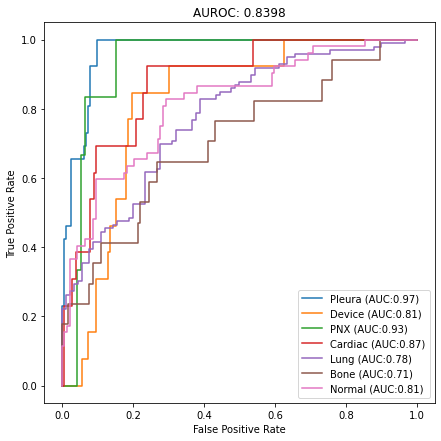

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(labels_HUM):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), weighted_predictions[:,i])

  #ax = fig.add_subplot(2,3,j)
  ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
  aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
plt.savefig(base_path+"X-RAY/results/results_TL/weighted_entropy_conv.png")

# Majority Voting

In [ ]:
predictions = []
for model in models: 
  predictions.append(model.predict(test_dataset))
predictions = np.array(predictions)

Majority voting with threshold 0.5

In [ ]:
binary_pred = predictions >= 0.5
binary_pred = binary_pred.astype(int)
votes = binary_pred.sum(axis=0)
final_pred = votes >=4
final_pred = final_pred.astype(int)

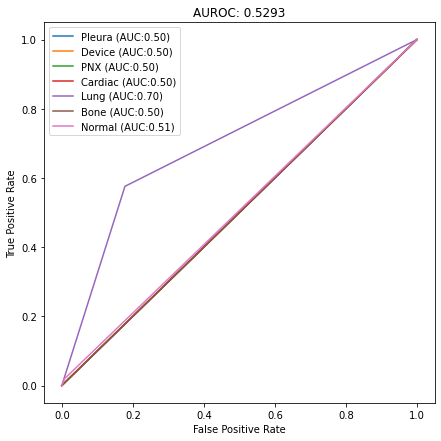

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(labels_HUM):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), final_pred[:,i])

  #ax = fig.add_subplot(2,3,j)
  ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
  aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
plt.savefig(base_path+"X-RAY/results_TL/maj_05.png")

Majority voting with threshold 0.2

In [ ]:
binary_pred = predictions >= 0.2
binary_pred = binary_pred.astype(int)
votes = binary_pred.sum(axis=0)
final_pred = votes >=4
final_pred = final_pred.astype(int)

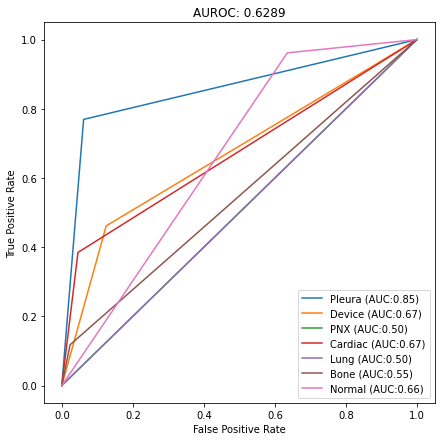

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(labels_HUM):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), final_pred[:,i])

  #ax = fig.add_subplot(2,3,j)
  ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
  aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
plt.savefig(base_path+"X-RAY/results_TL/maj_02.png")

# Voting

In [ ]:
predictions = []
for model in models: 
  predictions.append(model.predict(test_dataset))
predictions = np.array(predictions)

In [ ]:
from scipy.stats import entropy

entropies = entropy([predictions,1-predictions],base = 2)


In [ ]:
binary_pred = predictions >= 0.2
binary_pred = binary_pred.astype(int)
final_pred = np.average(binary_pred,axis=0)
final_pred = final_pred.astype(float)

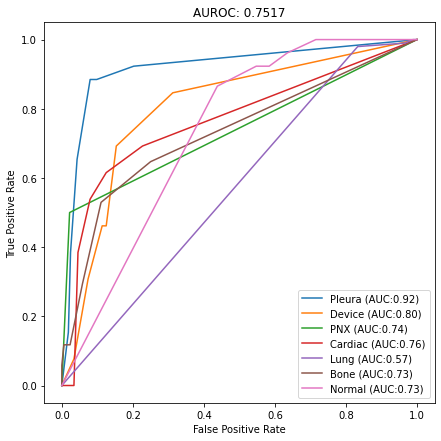

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(labels_HUM):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), final_pred[:,i])

  #ax = fig.add_subplot(2,3,j)
  ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
  aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
plt.savefig(base_path+"X-RAY/results_TL/voting.png")

# Single model performance


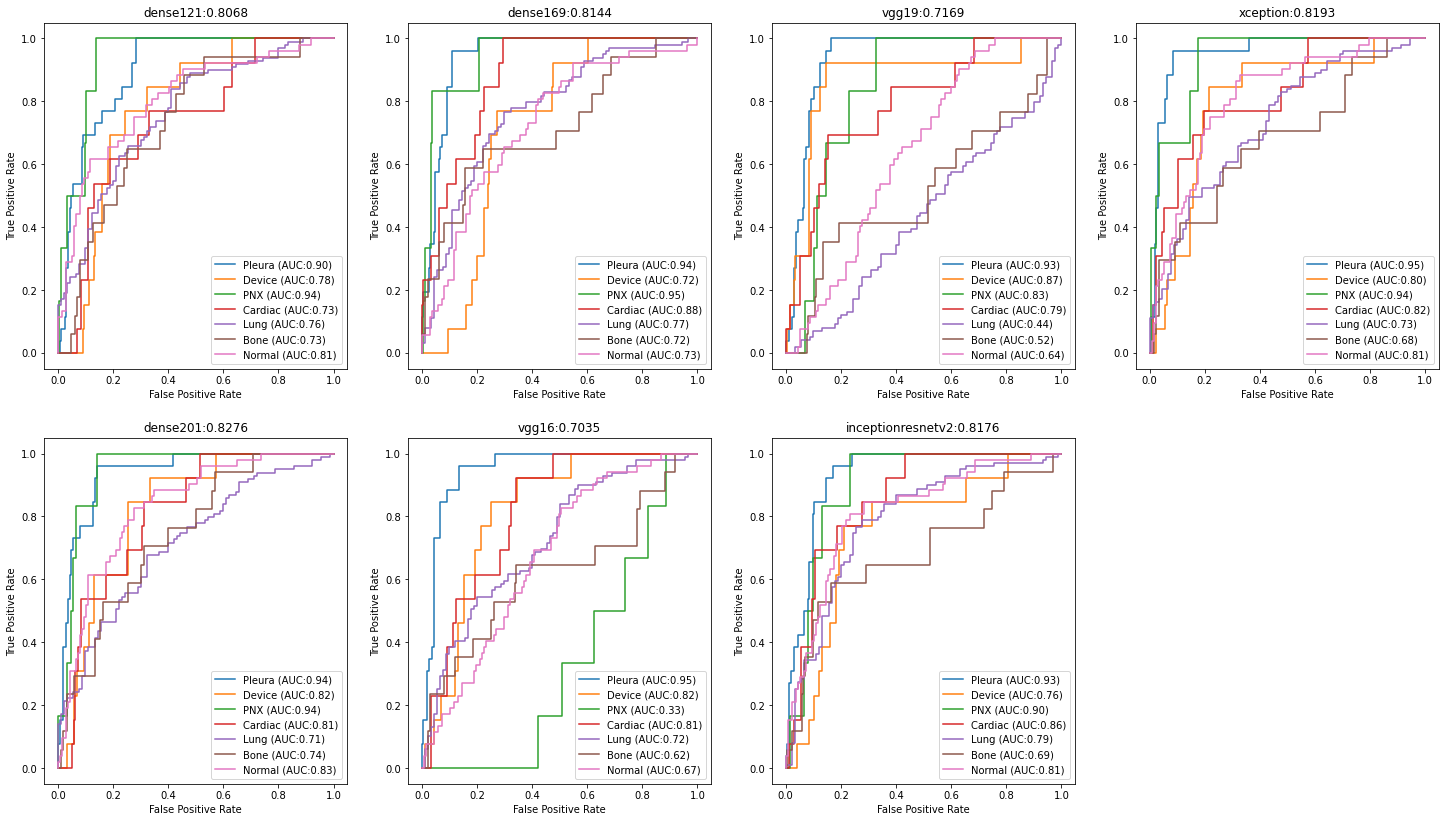

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


#fig, c_ax = plt.subplots(2,3, figsize = (15, 10))
fig = plt.figure(figsize=(25,14))


j = 1
for model in models:
  pred = model.predict(test_dataset)
  aurocs= []
  ax = fig.add_subplot(2,4,j)
  for (i, label) in enumerate(labels_HUM):
      fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), pred[:,i])
      #ax = fig.add_subplot(2,3,j)
      ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
      aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('{}:{:0.4f}'.format(models_list[j-1],np.mean(aurocs)))
  j+=1 
plt.savefig(base_path+"X-RAY/results_TL/single_performance.png")   


# Stacking

In [ ]:
def build_meta_learner_dataset(models,dataset):
  predictions = []
  for model in models: 
    predictions.append(model.predict(dataset))
  predictions = np.array(predictions)
  new_pred = []
  for i in range(predictions.shape[1]):
    new_pred.append(predictions[:,i])
  new_pred = np.array(new_pred)
  X = new_pred.reshape((new_pred.shape[0],-1))

  unbatched_dataset = dataset.unbatch()
  Y = []
  for _, labels in unbatched_dataset:
    Y.append(labels.numpy())
  Y = np.array(Y)
  return X , Y
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
train_X, train_Y= build_meta_learner_dataset(models,train_dataset)
test_X, test_Y= build_meta_learner_dataset(models,test_dataset)

rf.fit(train_X,train_Y.astype('int'))
predictions = rf.predict_proba(test_X)
prob_pred = np.array(predictions)[:,:,1].T

In [ ]:
hum_labels=["Pleura",  "Device", "PNX",  "Cardiac", "Lung", "Bone", "Normal"]

fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(hum_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), prob_pred[:,i])
    #ax = fig.add_subplot(2,3,j)
  ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
  aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
plt.savefig(base_path+"/X-RAY/transfer_learning_stacking")